# Task requirement 

* Perform some simple exploratory analysis and generate summary statistics to get a sense of what is in the data.
* Describe the quality of the data.
* Describe the relationship of the attributes with the label and share any interesting insights you’ve found.  
* Build a model to predict whether a given person is a good or bad credit risk.
* Generate a few visuals to convey data and model characteristics, these should be presentable to a non-technical business audience.
* Write all of this into a python notebook, upload to a git repo, and share the link with the us to review.  Be prepared to discuss your methodologies and approach.
* Assume the audience for your write-up is a non-technical stakeholder.
* Assume the audience for your code is a colleague who may need to read or modify it in the future.

# Part 1 -- Import necessary packages

In [5]:
import pandas as pd
import pyodbc
import numpy as np
import sys
import pathlib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap

pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', -1)

#  Part 2 -- Data importation and initial analysis 

In [68]:
#Read in data with pandas and do a preliminary analysis
df = pd.read_csv("Tenzing Assesment Data Set.csv")

# To be familiar with the DataFrame colomn names 
df.head() 

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,residence_since,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,'<0',6,'critical/other existing credit',radio/tv,1169,'no known savings','>=7',4,'male single',none,4,'real estate',67,none,own,2,skilled,1,yes,yes,good
1,'0<=X<200',48,'existing paid',radio/tv,5951,'<100','1<=X<4',2,'female div/dep/mar',none,2,'real estate',22,none,own,1,skilled,1,none,yes,bad
2,'no checking',12,'critical/other existing credit',education,2096,'<100','4<=X<7',2,'male single',none,3,'real estate',49,none,own,1,'unskilled resident',2,none,yes,good
3,'<0',42,'existing paid',furniture/equipment,7882,'<100','4<=X<7',2,'male single',guarantor,4,'life insurance',45,none,'for free',1,skilled,2,none,yes,good
4,'<0',24,'delayed previously','new car',4870,'<100','1<=X<4',3,'male single',none,4,'no known property',53,none,'for free',2,skilled,2,none,yes,bad


**Summary** 
* There are 20 columns of features/attributes data and 1 column of target data.
* Among the 20 columns of data, there are 13 categorical features and 7 numerical features. 
* Because most of the features are categorical, finding the right encoding methods might be important.  

In [6]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
checking_status           1000 non-null object
duration                  1000 non-null int64
credit_history            1000 non-null object
purpose                   1000 non-null object
credit_amount             1000 non-null int64
savings_status            1000 non-null object
employment                1000 non-null object
installment_commitment    1000 non-null int64
personal_status           1000 non-null object
other_parties             1000 non-null object
residence_since           1000 non-null int64
property_magnitude        1000 non-null object
age                       1000 non-null int64
other_payment_plans       1000 non-null object
housing                   1000 non-null object
existing_credits          1000 non-null int64
job                       1000 non-null object
num_dependents            1000 non-null int64
own_telephone             1000 non-null object
foreign_

**Summary** 

* When importing data from the csv file, Pandas' default interpretation of string (object) and integer types for each column is correct. So no specific type conversion is necessary. 

* The data set has no missing or null values. There is no need for further processing or cleaning. Some columns such as 'employment' have been 'discretized' and transformed into categorical strings. There might be some room to fine tune the rules for obtaining these string. 

In [7]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


**Summary** 

* From the summary statistics shown above, we see that there are some outliers (three standard deviations away from the mean) for columns such as 'duration', 'credit_amount' and 'age'. 

* In regression models we almost always need calculate the mean of a column of data ("regression" literally means "go back to mean"). However, outliers may strongly affect the calculation of mean. Thus, in general, outliers will affect the performance of regression models. **Here we mainly consider an prototype model and some possible corrections to the prototype. So the the issue of outliers will not be addressed.** 

* We will consider a logistic regression model. Thus normalization / standardization is unnecessary. 

In [8]:
df['class'].value_counts() 

good    700
bad     300
Name: class, dtype: int64

**Summary**:  
* We count the number of each class level in the target column. 
* Normally a class with 4:1 or bigger class ratio is considered to be an imbalanced or skewed class. The ratio here is 7:3. Therefore, the data set is not regarded as imbalanced by convention. However, because the data set is anyway on the edge of imbalance, it might still be beneficial to consider some techniques specially designed for imbalanced data.  

# Part 3 -- Exploratory analysis
We will explore some insights from the given data set, especially the relation between features/attributes and target. As mentioned earlier, there are two types of features in this data set: one is categorical and the other is numerical. Furthermore, the type of target class is also categorical. Therefore, the study of target-feature relation should be done in the following two ways: categorical-categorical and categorical-numerical. Target is always categorical but feature can be either categorical or numerical. 

### Categorical - categorical analysis
There are 13 categorical attributes as shown in the following list: categorical_columns. 

In [18]:
categorical_columns = ['checking_status','credit_history', 'purpose','savings_status', 'employment','personal_status',
                       'other_parties','property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 
                       'foreign_worker']

To analyze the relation between target and the above categorical attributes, we construct the following function: draw_cate_cate(column_name). This function will plot the relation of the categorical target class and the other categorical feature / attribute. 

In [88]:
def draw_cate_cate(column_name):

    # prepare dataframe for plotting
    df1=df.groupby(['class',column_name]).count()[['duration']]
    df1.reset_index(inplace=True)
    df1.columns=['class',column_name,'count']

    df1.loc[df1['class']=='good','count']=df1.loc[df1['class']=='good','count']*3/7
    # The 3/7 factor is due to the particular target class ratio 7:3 as we studied earlier. 
    # We should avoid such hard-coding if this function will be re-used in other place.
    
    df1=df1.pivot(index='class',columns=column_name,values='count')

    # Plotting
    ycmap = ListedColormap((sns.color_palette('bright'))) # deep, muted, pastel, bright, dark, and colorblind

    _=df1.plot.bar(figsize=(6.4, 4.4), cmap=ycmap,title=column_name+' vs Class (Grouped Bar Chart)')
    _=plt.ylabel('Count')
    _=plt.xticks(rotation=45)
    _=plt.legend(loc="upper center",prop={'size': 7})


    _=plt.show()

We next analyze the target-attribute relation for a few attributes. 

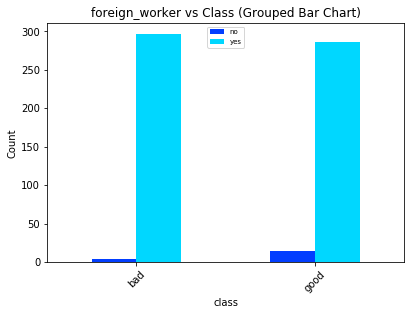

In [20]:
draw_cate_cate('foreign_worker')

We gain the following insights from the figure above:   

* The number of foreign workers accounts for most of the samples of either 'good' or 'bad'. However, the status of being foreign workers (light blue) has almost nothing to do with their probabilities of being 'bad' or 'good'. This is because, for foreign workers, the number of being 'bad' and the number of being 'good' are almost same. That is, the heights of two light blue bars are almost identical.  

* The non-foreign workers (dark blue) are more likely to be 'good'. The height of dark-blue bar for being 'good' is many times that of being 'bad'.  

* **A key point to note:** The count of all bars in the above graph is not the total number of samples, i.e. 1000. The reason for this is that the data set has much more 'good' samples than 'bad' (7:3). For a fair comparison, when plotting, we normalize the number of being 'good' by a factor of 3/7. Otherwise, the height of bars for 'good' would always much higher than those of being 'bad'. 

Let examine the class-attribute relation for another attribute 'savings_status'.

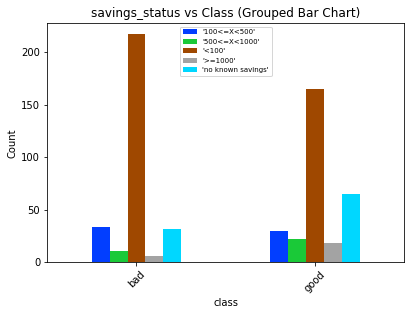

In [21]:
draw_cate_cate('savings_status')

We gain the following insights from the figure above:  

* For saving amount $X<100$ (dark orange), the number of being 'bad' is bigger than that of being 'good'. Also we find most samples in the data set belong to this category. 
* As saving amount becomes $100 \leq X < 500$ (dark blue), the number of being 'bad' is still slightly bigger than being 'good'. 
* As the saving amount becomes more, e.g. $500 \leq X < 1000$ (green), the number of being 'bad' is no longer bigger than being 'good', but becomes smaller (green).
* As the saving amount becomes even more, e.g. $ X \geq 1000$ (gray), the number of being 'good' becomes even more than that of being 'bad'. 
* We thus conclude that the more saving people have, the less likely they will be with 'bad' credit. 
* Finally another surprising result is that people without saving account are more likely being 'good'. 


### Categorical - numerical 
There are 7 numerical attributes as shown in the following list: numerical_columns. 

In [22]:
numerical_columns = ['duration','credit_amount','installment_commitment','residence_since','age',
                     'existing_credits','num_dependents']

To analyze the relation between target and the above numerical attributes, we construct the following function: draw_box(column_name). This function will plot the relation of the categorical target class and the other numerical feature / attribute. 

In [23]:
def draw_box(column_name):
    df1=df[['class',column_name]]

    # Make box plot
    _ = sns.boxplot(x='class',y=column_name, data = df1) 
    _ = plt.xlabel('class')
    _ = plt.ylabel(column_name)

    _ = plt.show()

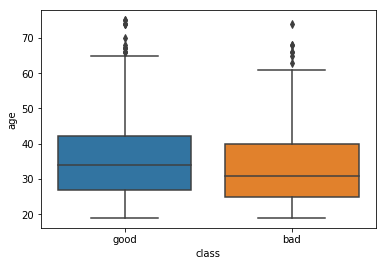

In [24]:
draw_box('age')

We gain the following insights from the figure above:  
* The median age for being 'bad' (the horizontal black line in the orange box) is smaller than that of being 'good' (the horizontal black line in the blue box).  
* Thus we conclude that people with younger age are more likely to have a 'bad' credit. 

Let's examine the target-attribute relation for another numerical attribute.  

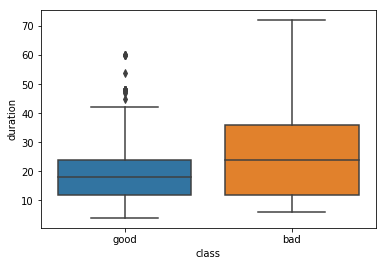

In [17]:
draw_box('duration')

We gain the following insights from the figure above:  
* The median duration for being 'bad' (the horizontal black line in the orange box) is bigger than that of being 'good' (the horizontal black line in the blue box), but also with bigger volatility.   
* We conclude that the longer the credit history, the more likely to be with 'bad' credit. This might be related to the fact volatility can sometimes be proportional to the square root of the time duration. Intuitively, we may deduct that although a rare event such as debt default is unlikely to happen over a short period of time, it might happen within a long period of time. 

# Part 4 -- Preparing data for modeling

* We have 13 categorical features/attributes in the data set, which should all be converted to numerical numbers before fitting a model. 

* There are many ways to encode categorical variables. For nominal categorical columns, try OneHot, Hashing, LeaveOneOut, and Target encoding, but avoid OneHot for high cardinality columns and decision tree-based algorithms.  For ordinal categorical columns try Ordinal (Integer), Binary, OneHot, LeaveOneOut, and Target etc. 

* It might be useful to try Ordinal encoding for some columns such as 'checking_status', 'savings_status', which have some 'ordering' components inside. Then encode other nominal categorical with OneHot, and finally concatenate them together. However, the Hashing encoding should not be appropriate because the number of levels for our categorical attributes are small. 

* For simplicity, we will only use OneHot encoding approach to encode all our categorical attributes. 

In [106]:
y = df['class'].replace('good',0).replace('bad',1).values
X = df.drop(['class'], axis = 1)
X = pd.get_dummies(X, drop_first=True).values

**Comments:**  
* In theory, for $N$ level categorical attribute, the dimension of OneHot vector should be $N-1$. This is why we use `drop_first=True`. However, we find that this does not matter a lot in the logistic regression model below. The only change of deleting `drop_first=True` is that f1 score goes from 0.783 to 0.782 for a cross-valid model used later. 

Next is a test for whether the OneHot encoding is correct in terms of the total levels obtained. 

In [107]:
sum_categorical_levels  = 0
for item in categorical_columns:
    sum_categorical_levels = sum_categorical_levels + len(df[item].unique())-1

total_num_columns = sum_categorical_levels + len(numerical_columns)
print(total_num_columns)
print(X.shape)

48
(1000, 48)


**Comments**:  
* The calculated total columns is same as the second dimension of data X, i.e., 48. Thus pd.get_dummies() therefore does the right job, at least in terms of dimensions. 
* If we delete `drop_first=True` from pd.get_dummies(), then the total dimension will become 61. As mentioned earlier, both cases give almost the same results. However, the 48 should be used in theory because not all the levels are independent in the case of 61 columns. Sometimes calculations without `drop_first=True` might cause problems, i.e, the so-called dummy variable trap. 

# Part 5 -- A prototype model 

### Model with logistic regression

In [112]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Fit a logistic regression model to our data
prototype_model = LogisticRegression(solver = 'lbfgs', max_iter = 500)
prototype_model.fit(X_train, y_train)

# Obtain model predictions
predicted = prototype_model.predict(X_test)

# Print the classifcation report and confusion matrix
print('Classification report:\n', classification_report(y_test, predicted))
conf_mat = confusion_matrix(y_true=y_test, y_pred=predicted)
print('Confusion matrix:\n', conf_mat)

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84       210
           1       0.65      0.44      0.53        90

   micro avg       0.76      0.76      0.76       300
   macro avg       0.72      0.67      0.68       300
weighted avg       0.75      0.76      0.75       300

Confusion matrix:
 [[188  22]
 [ 50  40]]


### The interpretation of the results

* For class = 0 ('good'), the values of precision and recall are 0.79 and 0.90 respectively. These are much better than the corresponding values of 0.65 and 0.44 for class 1('bad'). This indicates, among the 90 class = 1('bad') cases, only 40 of them are discovered or 'recalled', which is just 44% of them. 

* If predicting both 'good' and 'bad' are equally important to us, then the above results are sort of OK. However, if we focus more on predicting the 'bad' case, then 44% prediction is very bad. 

* The very different predictions for class = 1 and class = 0 are probably due to the imbalance data set where the ratio of 'good' to 'bad' is 7:3. If we indeed focus on predicting 'bad' case, then we should improve the model by employing techniques developed specifically for imbalanced data. Various of such techniques can be found in the following link: https://github.com/ljyang100/dataScience/blob/master/machineLearning/applications/anomaly%20_%20fraud%20detection/fraud%20detection.pdf. One of such ways is to re-balance the data using the Synthetic Minority Over-sampling Technique (SMOTE).  
 

# Part 6 Feature selection with filter methods
* Feature selection and extraction are very important in machine learning.We next provide some feature selection and extraction approaches that could generally increase the performance of a model, including the prototype logistic model introduced earlier. 
* Feature selection/extraction sometimes can be even more important than building a model. In fact, sometimes performing featuring extraction itself is building a model. For example, in image/face recognition with deep learning, we need extract a low dimensional (a few hundreds) feature from a high-dimensional feature (tens or hundreds of thousands in dimension). Such a feature extraction is usually done by neural network (CNN), which is itself a complicated model. This feature extraction from much high to much low dimension makes it possible for image/face recognition through another model. 
* Redundant features will not only increase the calculation burden, but also could increase the variance of the prediction (overfitting).  


### Feature selection for categorical-categorical relation with $\chi^2$ testing  
* Calculate the dependence of the categorical target on each of 13 categorical attributes. If we find the target depends strongly on a specific feature, then the feature must be a 'good' feature for prediction. 
* To quantify the dependence of two categorical variables, we use $\chi^2$ statistics. If the $\chi^2$ is very big, or the corresponding $p$ value is very small, then the two variables are strongly dependent.  
* Below are the calculations of $\chi^2$ statistics between the target and all other categorical attributes.  

In [42]:
import pandas as pd
from scipy import stats

for categorical_variable in categorical_columns:
    crosstab = pd.crosstab(df[categorical_variable], df['class'])
    chi_square, p_value, degree_of_freedom, _ = stats.chi2_contingency(crosstab)
    print("chi_square: " + str(chi_square) + " p_value: " + str(p_value) + " for " + "'" + categorical_variable + "'.")
    

chi_square: 123.72094351626559 p_value: 1.2189020722893845e-26 for 'checking_status'.
chi_square: 61.691396964595505 p_value: 1.2791872956750962e-12 for 'credit_history'.
chi_square: 33.35644686141815 p_value: 0.00011574910079691586 for 'purpose'.
chi_square: 36.098928192418704 p_value: 2.761214238568249e-07 for 'savings_status'.
chi_square: 18.3682738466968 p_value: 0.001045452349140254 for 'employment'.
chi_square: 9.60521395933605 p_value: 0.02223800546926877 for 'personal_status'.
chi_square: 6.645366537264244 p_value: 0.036055954027247206 for 'other_parties'.
chi_square: 23.719551283864707 p_value: 2.8584415733250017e-05 for 'property_magnitude'.
chi_square: 12.839187735866135 p_value: 0.0016293178186473534 for 'other_payment_plans'.
chi_square: 18.19984158256362 p_value: 0.00011167465374597684 for 'housing'.
chi_square: 1.8851560280131707 p_value: 0.5965815918843431 for 'job'.
chi_square: 1.1725585310208857 p_value: 0.27887615430357415 for 'own_telephone'.
chi_square: 5.821575915

From above, we know the attribute 'checking_status' depend strongest on the target, as its $\chi^2$ (chi_square) has the largest value 123.7209 (or with smallest $p$ value). **So the 'checking_status' is the best categorical feature/attribute**. This can also be clearly seen in the following figure.   

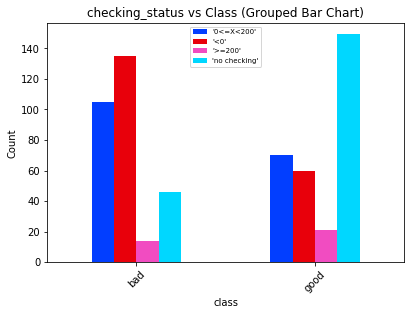

In [44]:
draw('checking_status')

Almost every categorical level is strongly dependent on the target class, for example: '<0' case (red) has more probability to be 'bad'; 'no checking' case (light blue) has more probability to be 'good'. In other words, their bar heights are strongly related to whether they are 'good' or 'bad'.  

Now we check the second best categorical attribute 'credit_history' with the $\chi^2$ value of 61.69139. Again we see that each level of the variable depends heavily on 'good' or 'bad'. In other words, the same color bars for the 'good' and 'bad' are very different (except the gray and dark orange). 

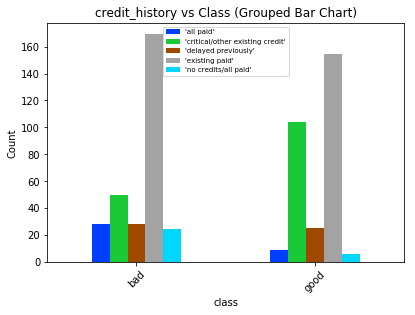

In [47]:
draw('credit_history')

After checking the best and second best categorical features, let's check the two worst ones, 'job' and 'own_telephone'. Their $\chi^2$ values are respectively 1.8851 and 1.1725, much smaller than the counterparts of the two best ones introduced earlier. 

For the two worst ones, the levels (the heights of same color bars) are almost same for 'good' and 'bad'. Or, they are independent of the target class 'good' and 'bad'. 

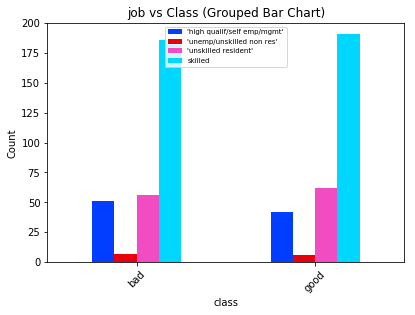

In [45]:
draw('job')

In the above figure, the heights of two light blue bars are almost same. Similar conclusions hold the bars of other colors. This indicates the attribute 'job' and target class have almost no depending relation.  

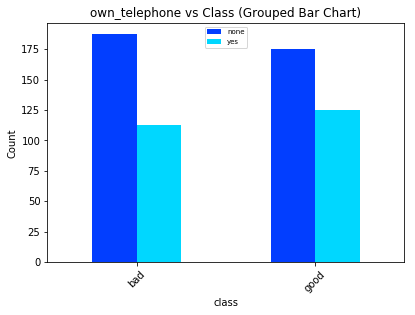

In [46]:
draw('own_telephone')

In the above figure, two blue bars are with similar height. Same thing for two light-blue bars. So attribute 'own_telephone' and target class has no appreciable dependence. 

### Test feature selection by eliminating of two best/worst categorical attributes
To verify our conclusions, we now run a cross-validated logistic regression model below. First we run the model without eliminating any attributes. 

In [93]:
y = df['class'].replace('good',0).replace('bad',1).values
X = df.drop(['class'], axis = 1)
X = pd.get_dummies(X, drop_first=True).values

In [94]:
from sklearn.linear_model import LogisticRegressionCV
cross_valid = LogisticRegressionCV(cv=5, random_state=0,solver='lbfgs', max_iter=1000,
                            multi_class='multinomial').fit(X, y)


In [95]:
cross_valid.score(X, y) 

0.783

Then we run the model by only eliminating the two worst categorical attributes 'job' and 'own_telephone'. 

In [96]:
y = df['class'].replace('good',0).replace('bad',1).values
X = df.drop(['class'], axis = 1)
X = X.drop(['job'], axis = 1)
X = X.drop(['own_telephone'], axis = 1)
X = pd.get_dummies(X, drop_first=True).values

In [97]:
cross_valid = LogisticRegressionCV(cv=5, random_state=0,solver='lbfgs', max_iter=1000,
                            multi_class='multinomial').fit(X, y)
cross_valid.score(X, y) 

0.779

Finally we run the model by only eliminating two best categorical attributes.

In [98]:
y = df['class'].replace('good',0).replace('bad',1).values
X = df.drop(['class'], axis = 1)
X = X.drop(['checking_status'], axis = 1)
X = X.drop(['credit_history'], axis = 1)
X = pd.get_dummies(X, drop_first=True).values


In [99]:
cross_valid = LogisticRegressionCV(cv=5, random_state=0,solver='lbfgs', max_iter=1000,
                            multi_class='multinomial').fit(X, y)
cross_valid.score(X, y) 

0.747

**Summary**: 

* By eliminating the two worst categorical variables, the performance goes down by 0.4%, almost no effect. So the two worst features can be eliminated to reduce data dimension. 
* By eliminating the two best categorical variables, the performance goes down by 3.7%, an appreciable effect. So we cannot eliminate these two best categorical features. 
* The $\chi^2$ testing approach **can thus help us to preliminarily design and select important categorical features when a target is also categorical.** 
* We have studied only the target-feature relation by $\chi^2$ testing, where we keep a feature if $\chi^2$ is very big and eliminate a feature when $\chi^2$ is very tiny.
* We can also do feature selection by studying the feature-feature relation by $\chi^2$ testing if the two features are both categorical. However, unlike the examination of target-feature relation, here we eliminate a feature when the $\chi^2$ is very big. 

### Feature selection for categorical-numerical relation with analysis of variance (ANCOVA) 
Like the categorical-categorical case, we first draw the target-attribute relation to check whether the target and feature is strongly related. The difference here is that the attribute is a continuous variable instead of categorical. We thus draw the box plot to show these relations. Let's first check the target-'duration' plot below.  

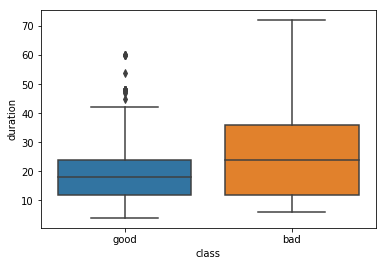

In [100]:
draw_box('duration')

It is clear that the 'duration' distributions for 'good' and 'bad' cases are different. Thus 'duration' is dependent on the target class 'good' and 'bad'. For example, for the 'bad' case, the median 'duration' value (the black line in orange box) is higher than that of 'good' case (the black line in blue box). 

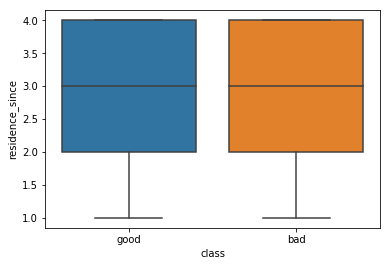

In [101]:
draw_box('residence_since')

The distributions for 'residence_since' are similar to each other for 'good' and 'bad'. Thus we conclude that the 'residence_since' is weakly related to the target class.  

The quantitatively describe the above dependences, we may use the F-value, as employed ANCOVA. This is different from the $\chi^2$ as we used in the categorical-categorical case. Because now we are considering categorical-numerical case, we thus select features based on the F-value. 

### Feature selection for numerical-numerical relation with correlation
For numerical-numerical case, we usually use correlation to select features. If target-feature has a strong correlation, then keep the feature. If feature-feature has a very strong correlation, then eliminate one of features. Let's plot the 'duration'-'credit_amount' relation first.   

In [102]:
def draw_plot(column_name1,column_name2):
    _=plt.plot(np.array(df[column_name1]),np.array(df[column_name2]),marker='.', linestyle='none',color='blue') 
    _=plt.xlabel(column_name1)
    _=plt.ylabel(column_name2)

    _=plt.show()

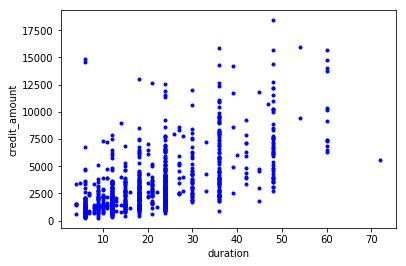

In [103]:
draw_plot('duration','credit_amount')

There is sort of correlation: as duration becomes larger, credit_amount also has a tendency to be larger. However, they are far from strong correlated. In this data set, the correlation among different numerical features are normally small. So it is not justifiable to eliminate one of features. This can be further proved by the following code where we will eliminate a feature if the feature-feature correlation is bigger than 0.95. 

In [87]:
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# print(upper)

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
print(to_drop)

[]


# Part 7 Feature selection with wrapper methods

The feature selection in Part 6 considers feature-feature or feature-target relation without considering the whole performance. With wrapper methods such as 'sequential feature selection algorithm', we always consider a combination of features with best metric such as ROC_AUC. This type of approach is usually expensive in calculation and thus is not suitable for very big data set with high dimension.  

An example of using 'sequential feature selection algorithm' can be found in the following link: 

https://github.com/ljyang100/dataScience/blob/master/machineLearning/featureEngineering/forward%20step-wise%20feature%20selection%20using%20ROC_AUC.pdf


# Part 8 Feature extraction, nonlinear models and other possible improvements

* Feature selection in Part 6 and 7 only selects from the available features. Feature extraction, however, may create new features by linearly or nonlinearly combine the original features. Typical ways of doing so include linear dimension reduction ways such as PCA and LDA. LDA is particularly useful for maximizing the separation of classes. Nonlinear dimension reduction techniques such as image encoding, word embedding, etc. can significantly reduce the original dimension of data without losing essential information. 

* In this project, we employ a linear classifier: logistic regression model. However, the target and feature relation might be nonlinear. If so, then we may improve the performance by employing typical nonlinear models such as support vector machine, tree-based models such as random forest, neural network, etc. 
